# Setup

En este notebook "transribí" el modelo que surgió de las caminatas al azar, el cual estaba armado con base_model. Lo escribi todo a mano para verificar que lo que arma base_model sea lo que corresponde, lo entrene y me fije que tenga la misma performance. Aproveché para ver que pasa si vario el sampleo, lo que me llevo a darme cuenta de que había que regularizar un poco la red.

De paso mire por qué el error es relativamente alto aunque el AUC es muy bueno. Intuitivamente, pense que el modelo podia estar clasificando muy mal algunos outliers y por eso el error explota, es un promedio. Para ver si es as´ tome los datos de entrenamiento y calcule el error, en vez de reducirlo (i.e, promediarlo) como se hace durante entrenamiento, me quedé con todos los valores y los plotee. Sucede masomenos lo que pensaba, el hist. del error decae rápidamente pero hay unos pocos ejemplos donde el modelo comete un error muy grande. Esto me corre el promedio.

Por otro lado, como lo que nos interesa es "ordenar" cosas, está bien que el modelo no entregue una proba de 0 o 1 en cada caso, necesitamos valores de proba intermedios. Pero estos valores intermedios para log loss están "mal". 

En cambio, para AUC, mientras respete el orden de las probas, está bien.

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch_geometric import seed_everything
from torch_geometric.nn import SAGEConv, to_hetero
import seaborn as sns

import sys
sys.path.append("../../..")
from src.models import training_utils, base_model,sage_ones, prediction_utils

seed = 4
seed_everything(seed)

data_folder = f"../../../data/processed/graph_data_nohubs/merged_types/split_dataset/"
feature_folder = "../../../data/processed/feature_data/"
reports_folder = "../../../reports/"
results_folder = "../../../reports/random_walks/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data

In [2]:
walk_1_results = pd.read_csv(results_folder+"walk_3/random_walk_results.csv",index_col=0)
walk_2_results = pd.read_csv(results_folder+"walk_4/random_walk_results.csv",index_col=0)

walk_2_results["walk"] = 4
walk_1_results["walk"] = 3 
total_walk = pd.concat([walk_1_results,walk_2_results]).reset_index(names="walk_index")
total_walk["T"] = total_walk.walk.apply(lambda x: 0.1 if x == 3 else 0.2)

model_params = total_walk.sort_values(by="mean_auc",ascending=False).iloc[0].to_dict()
model_params["supervision_types"] = [("gene_protein","gda","disease")]

In [3]:
seeds = [4]
data = []
for seed in seeds:
    datasets, node_map = training_utils.load_data(data_folder+f"seed_{seed}/")
    data.append(datasets)

full_set = torch.load(data_folder+f"seed_{seeds[-1]}/full_dataset.pt")
node_df = pd.read_csv(data_folder+f"seed_{seeds[-1]}/tensor_df.csv",index_col=0).set_index("node_index",drop=True)

# Trato de escribir el modelo a mano

In [4]:
class GraphBlock(torch.nn.Module):
    def __init__(self,input_dim,output_dim,dropout,residual_block):
        super().__init__()

        self.residual_block = residual_block
        self.conv = SAGEConv(input_dim,output_dim,aggr="mean")
        self.bn = torch.nn.BatchNorm1d(output_dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.relu = torch.nn.LeakyReLU()
    
    def forward(self,x,edge_index):
        identity = x
        out = self.conv(x,edge_index)
        out = self.bn(out)
        out = self.dropout(out)
        out = self.relu(out)

        if self.residual_block:
            out += identity
            out = torch.nn.functional.leaky_relu(out)
        
        return out

    def reset_parameters(self):
        self.conv.reset_parameters()
        self.bn.reset_parameters()

    
class PostProcessMLP(torch.nn.Module):
    def __init__(self,input_dim,output_dim,dropout):
        super().__init__()

        self.post_linear_1 = torch.nn.Linear(input_dim,output_dim)
        self.post_linear_bn = torch.nn.BatchNorm1d(output_dim)
        self.post_linear_dropout = torch.nn.Dropout(dropout)
        self.post_linear_act = torch.nn.LeakyReLU()
        self.post_linear_2 = torch.nn.Linear(output_dim,output_dim)

    def forward(self,x):
        x = self.post_linear_1(x)
        x = self.post_linear_bn(x)
        x = self.post_linear_dropout(x)
        x = self.post_linear_act(x)
        x = self.post_linear_2(x)

        return x
    
    def reset_parameters(self):
        self.post_linear_1.reset_parameters()
        self.post_linear_bn.reset_parameters()
        self.post_linear_2.reset_parameters()

class Encoder(torch.nn.Module):
    def __init__(self,output_dim,dropout,metadata):
        super().__init__()

        self.graph_layer_1 = to_hetero(GraphBlock(-1,output_dim,0.5,False),metadata,aggr="mean")
        self.graph_layer_2 = to_hetero(GraphBlock(output_dim,output_dim,dropout,True),metadata,aggr="mean")
        self.graph_layer_3 = to_hetero(GraphBlock(output_dim,output_dim,dropout,True),metadata,aggr="mean")
        self.post_mlp = to_hetero(PostProcessMLP(output_dim,output_dim,dropout),metadata)

    
    def forward(self,x:dict,edge_index:dict):
        x = self.graph_layer_1(x,edge_index)
        x = self.graph_layer_2(x,edge_index)
        x = self.graph_layer_3(x,edge_index)
        x = self.post_mlp(x)
        return x

class InnerProductDecoder(torch.nn.Module):
    def __init__(self,supervision_types):
        super().__init__()
        self.supervision_types = supervision_types

    def forward(self,x:dict,edge_label_index:dict) -> dict:
        pred_dict = {}
        for edge_type in self.supervision_types:
            edge_index = edge_label_index[edge_type]

            source_type, _ , target_type = edge_type
            
            x_source = x[source_type]
            x_target = x[target_type]

            source_index, target_index = edge_index[0], edge_index[1]

            nodes_source = x_source[source_index]
            nodes_target = x_target[target_index]

            pred = (nodes_source * nodes_target).sum(dim=1)

            pred = torch.sigmoid(pred)
            pred_dict[edge_type] = pred
        
        return pred_dict

class Model(torch.nn.Module):
    def __init__(self,metadata,supervision_types):
        super().__init__()
          
        self.encoder = Encoder(64,0.1,metadata)
        self.decoder = InnerProductDecoder(supervision_types)
        self.loss_fn = torch.nn.BCELoss()
        self.supervision_types = supervision_types
    
    
    def forward(self,x:dict,edge_index:dict,edge_label_index:dict) -> dict:
        x = self.encoder(x,edge_index)
        pred = self.decoder(x,edge_label_index)
        return pred
    
    def loss(self, prediction_dict, label_dict):
        loss = 0
        for edge_type,pred in prediction_dict.items():
            y = label_dict[edge_type]
            loss += self.loss_fn(pred, y.type(pred.dtype))
        return loss

# Run experiment aver si funciona igual

In [20]:
model_params["sample_epochs"] = 1
pd.DataFrame.from_dict(model_params).T

,0
walk_index,22
hidden_channels,64
micro_aggregation,mean
macro_aggregation,mean
layer_connectivity,skipsum
L2_norm,False
pre_process_layers,0
msg_passing_layers,3
post_process_layers,2
normalize_output,False


In [5]:
def run_experiment(params, train_set, val_set,negative_sampler):
    # Initialize node features
    if params["feature_type"] not in ["lsa","lsa_norm","lsa_scaled"]:
        train_set = training_utils.initialize_features(
            train_set, params["feature_type"], params["feature_dim"]
        )
        val_set = training_utils.initialize_features(
            val_set, params["feature_type"], params["feature_dim"]
        )
    else:
        #TODO: sacar el data_folder este
        train_set = training_utils.initialize_features(
            train_set, params["feature_type"], params["feature_dim"], feature_folder
        )
        val_set = training_utils.initialize_features(
            val_set, params["feature_type"], params["feature_dim"], feature_folder
        )

    train_set.to(device)
    val_set.to(device)
    model = Model(train_set.metadata(),[("gene_protein","gda","disease")])
    model = model.to(device)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"]
    )
    train_losses = []
    val_losses = []
    train_scores = []
    val_scores = []

    epochs = params["epochs"]

    early_stopper = training_utils.EarlyStopper(params["patience"], params["delta"])
    train_label_index = train_set["gene_protein","gda","disease"]["edge_label_index"]
    for epoch in range(epochs):
        #Resample negative supervision links every k epochs
        if epoch%params["sample_epochs"] == 0:
            # sample_index = torch.randint(high=train_label_index.shape[1], size=(round(params["sample_ratio"]*train_label_index.shape[1]),))
            # positive_sample = train_label_index[:,sample_index]

            # positive_sample = train_label_index
            new_train_label_index, new_train_label = negative_sampler.get_labeled_tensors(train_label_index.cpu(),"corrupt_both")
            train_set["gene_protein","gda","disease"]["edge_label_index"] = new_train_label_index.to(device)
            train_set["gene_protein","gda","disease"]["edge_label"] = new_train_label.to(device)

        train_loss = training_utils.train(model, optimizer, train_set)
        val_loss = training_utils.get_val_loss(model, val_set)

        train_score = training_utils.test(model, train_set)
        val_score = training_utils.test(model, val_set)

        train_losses.append(train_loss)
        train_scores.append(train_score)

        val_scores.append(val_score)
        val_losses.append(val_loss)

        if early_stopper.early_stop(val_loss):
            print("Early stopping")
            break

    val_auc = training_utils.test(model, val_set)
    curve_data = [train_losses, val_losses, train_scores, val_scores]

    return val_auc, model, curve_data

def run_multiple_seeds(datasets,experiment_params,negative_sampler):
    experiment_metrics = []
    models = []
    curves = []
    for seed_dataset in datasets:
        train_data, val_data = seed_dataset
        seed_auc, trained_model, training_curve = run_experiment(experiment_params,train_data,val_data,negative_sampler)
        experiment_metrics.append(seed_auc)
        models.append(trained_model)
        curves.append(training_curve)
    
    metrics = (np.mean(experiment_metrics),np.std(experiment_metrics))
    
    return [metrics, models, curves]

/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch_sparse/tensor.py:511: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  return torch.sparse_csr_tensor(rowptr, col, value, self.sizes())


(0.898, 0.0)


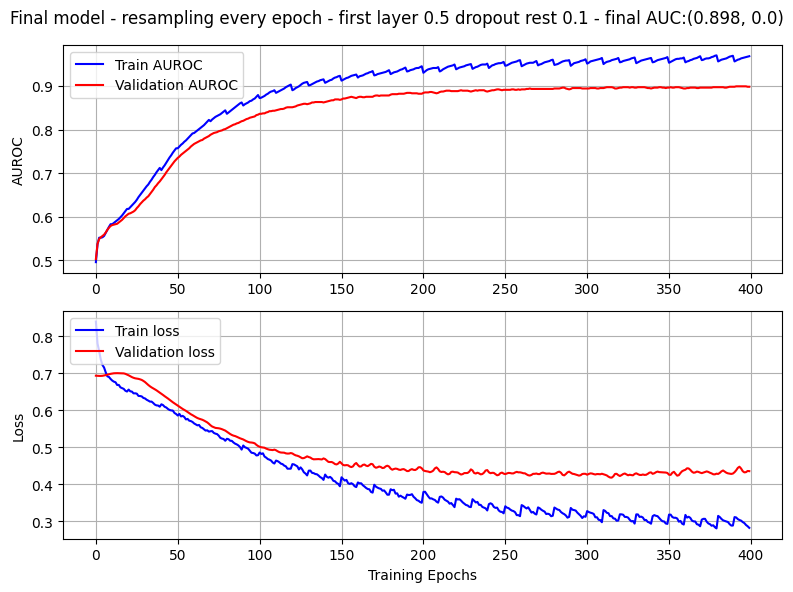

In [8]:
negative_sampler = training_utils.NegativeSampler(full_set,("gene_protein","gda","disease"),full_set["gene_protein"]["degree_gda"],full_set["disease"]["degree_gda"])
results = {}

metrics,models,curves = run_multiple_seeds(data,model_params,negative_sampler)
print(metrics)

training_utils.plot_training_stats_sep(f"Final model - resampling every epoch - first layer 0.5 dropout rest 0.1 - final AUC:{metrics}",*curves[0])

In [95]:
modelo = models[0]
datos = data[0][0]

datos = training_utils.initialize_features(datos, model_params["feature_type"], model_params["feature_dim"], feature_folder)


train_label_index = datos["gene_protein","gda","disease"]["edge_label_index"]
new_train_label_index, new_train_label = negative_sampler.get_labeled_tensors(train_label_index.cpu(),"corrupt_both")

datos["gene_protein","gda","disease"]["edge_label_index"] = new_train_label_index
datos["gene_protein","gda","disease"]["edge_label"] = new_train_label

In [96]:
with torch.no_grad():
    modelo.eval()
    predictions = modelo(datos.x_dict,datos.adj_t_dict,datos.edge_label_index_dict)
    edge_label = datos.edge_label_dict

predictions

{('gene_protein',
  'gda',
  'disease'): tensor([0.9428, 0.9550, 0.8785,  ..., 0.3447, 0.0025, 0.0636])}

In [97]:
pred = list(predictions.values())[0]
lab = edge_label[("gene_protein","gda","disease")]

loss_fn = torch.nn.BCELoss(reduction="none")
results = loss_fn(pred,lab)

In [106]:
np.median(results.numpy())

0.079651505

In [102]:
np.mean(results.numpy())

0.28906128

Text(0.5, 1.0, 'Log loss por cada ejemplo - train - positivos y negativos')

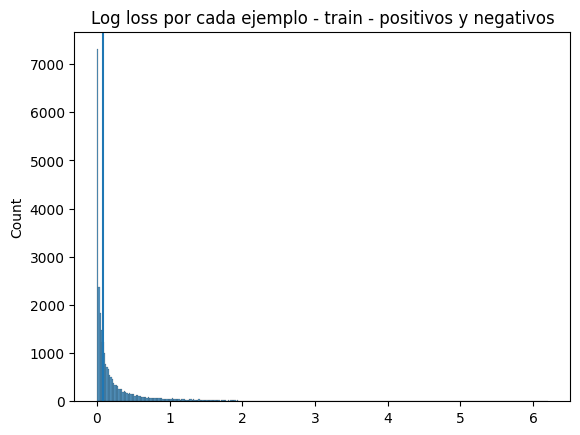

In [108]:
plt.figure()
sns.histplot(results.numpy())
plt.axvline(x=np.median(results.numpy()))
plt.title("Log loss por cada ejemplo - train - positivos y negativos")

In [121]:
corte = np.where(lab == 0)[0][0]
positivos = results.numpy()[0:corte]
negativos = results.numpy()[corte:]

Text(0.5, 1.0, 'Log loss por cada ejemplo - train - positivos')

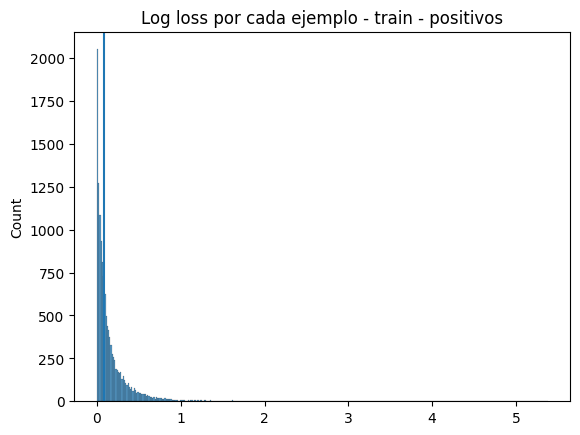

In [125]:
plt.figure()
sns.histplot(positivos)
plt.axvline(x=np.median(positivos))
plt.title("Log loss por cada ejemplo - train - positivos")

Text(0.5, 1.0, 'Log loss por cada ejemplo - train - negativos')

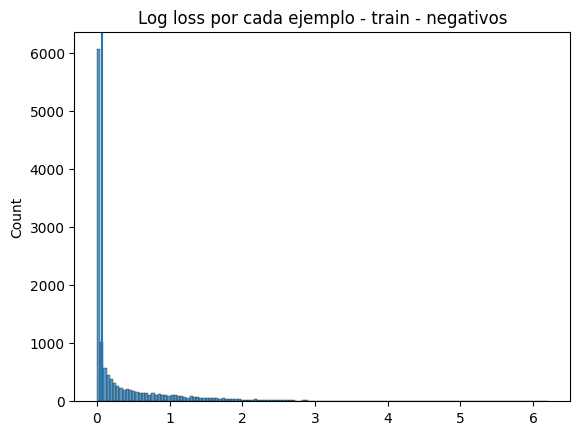

In [147]:
plt.figure()
sns.histplot(negativos)
plt.axvline(x=np.median(negativos))
plt.title("Log loss por cada ejemplo - train - negativos")

Tomo un ejemplo de enlace donde el modelo comete un error muy grande, para ver si es un caso difícil, o si el nodo está desconectado

In [135]:
np.where(positivos == positivos.max())

(array([1231, 5997]),)

In [157]:
edge = (train_label_index[0][5997].item(),train_label_index[1][5997].item())

In [158]:
node_df[(node_df.tensor_index == edge[0]) & (node_df.node_type == "gene_protein")]

,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
10727,54469,ZFAND6,gene_protein,disgenet,14157,NaN,NaN,8.0,3.0,0.0,11.0


In [159]:
node_df[(node_df.tensor_index == edge[1])&(node_df.node_type == "disease")]

,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
24781,C0520757,Delayed Emergence from Anesthesia,disease,disgenet,11822,NaN,NaN,2.0,0.0,0.0,2.0


Ok, es una enfermedad de grado bastante bajo. Puede haber quedado desconectada del grafo, esto es así? Lo veo cargando mapped_dataset, que tiene guardado que enlace quedó en cada split.

In [163]:
mapped_dataset = prediction_utils.MappedDataset(datos,node_map,("gene_protein","gda","disease"))
mapped_df = mapped_dataset.dataframe
mapped_df = mapped_df.rename(columns={x: x.replace("_source","").replace("_target","") for x in mapped_df.columns})

In [167]:
mapped_df[mapped_df.disease == 24781]

,gene_protein,disease,torch_gene_protein_index,torch_disease_index,label,edge_type
5997,10727,24781,14157,11822,1.0,supervision
52563,10526,24781,3719,11822,NaN,message_passing


# Ver despues

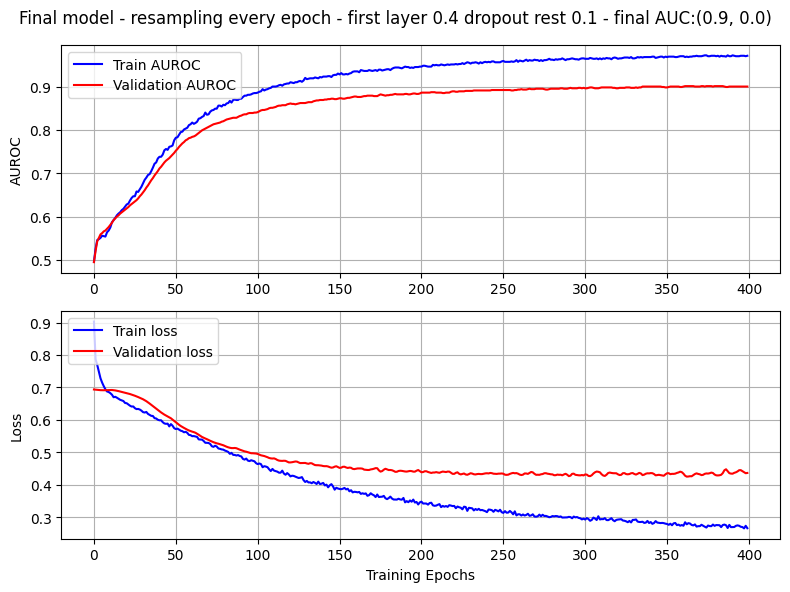

In [129]:
training_utils.plot_training_stats_sep(f"Final model - resampling every epoch - first layer 0.4 dropout rest 0.1 - final AUC:{metrics}",*curves[0])

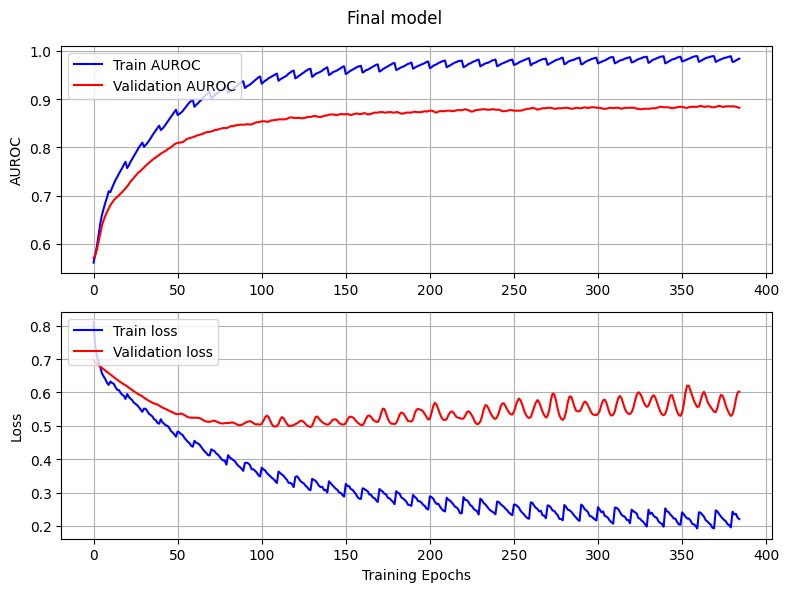

In [75]:
training_utils.plot_training_stats_sep("Final model",*curves[3])